# Jupyter Notebook for Traffic

## Import Libraries

In [2]:
from pathlib import Path
from datetime import datetime
import os

import numpy as np
import pandas as pd
from scapy.compat import raw
from scapy.layers.inet import IP, UDP
from scapy.layers.l2 import Ether
from scapy.packet import Padding
#from scipy import sparse

from joblib import Parallel, delayed

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.constraints import maxnorm

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sn

from utils_new_3 import should_omit_packet, read_pcap, PREFIX_TO_TRAFFIC_ID_NEW

## Define Necessary Function

In [3]:
def inttobit(n):
    return [1 if digit=='1' else -1 for digit in '{0:056b}'.format(n)]

def bintoint(binary):
    number = 0
    for b in binary:
        number = (2*number)+int(b)
    return number

def conv_header(proto, sport, dport, size):
    proto_bin = [int(x) for x in '{0:08b}'.format(proto)]
    sport_bin = [int(x) for x in '{0:016b}'.format(sport)]
    dport_bin = [int(x) for x in '{0:016b}'.format(dport)]
    size_bin = [int(x) for x in '{0:016b}'.format(size)]
    metric = proto_bin+sport_bin+dport_bin+size_bin
    metric_int = bintoint(metric)
    return metric, metric_int

#convert weights to binary weights and to integer
def convert_weight_to_file(weight_data, filename):
    weight= []
    weights = []
    for i in weight_data:
        for j in i:
            if j < 0:
                weight.append(0)
            else:
                weight.append(1)
        weights.append(bintoint(weight))
        weight.clear()
    txtfile = open(filename, "w")
    for i in weights:
        txtfile.write(str(i) + "\n")
    txtfile.close()


def transform_packet(packet):
    if should_omit_packet(packet):
        return None

    if 'IP' in packet:
        size =  int(packet.len)
        try:
            proto = (packet.proto)
        except AttributeError:
            proto = 0
        try:
            sport = (packet.sport)
            dport = (packet.dport)
        except AttributeError:
            sport = 0
            dport = 0

        proto = [int(x) for x in '{0:08b}'.format(proto)]
        sport = [int(x) for x in '{0:016b}'.format(sport)]
        dport = [int(x) for x in '{0:016b}'.format(dport)]
        size =  [int(x) for x in '{0:016b}'.format(size)]
        #metric = [(proto/255), (sport/65535), (dport/65535), (size/65535)]
        metric = proto + sport + dport + size
        adapted_metric = [-1 if x == 0 else x for x in metric]
    #arr = packet_to_sparse_array(packet)
        if len(adapted_metric) == 56:
            return np.asarray(adapted_metric)

def transform_pcap(path, output_path: Path = None, output_batch_size=10000):
    if Path(str(output_path.absolute()) + '_SUCCESS').exists():
        print(output_path, 'Done')
        return
    
    start = datetime.now()
    print('########################################')

    print('Processing', path, '. Started at:', start)

    rows = []
    batch_index = 0
    #for pcap in path.iterdir():
    for i, packet in enumerate(read_pcap(path)):
        arr = transform_packet(packet)
        if arr is not None:
            # get labels for app identification
            prefix = path.name.split('.')[0].lower()
            #app_label = PREFIX_TO_APP_ID.get(prefix)
            traffic_label = PREFIX_TO_TRAFFIC_ID_NEW.get(prefix)
            ###### ADDED: check if the the label exist or not
            #if app_label is not None and traffic_label is not None:
            if traffic_label is not None:
                row = {
                    #'app_label': app_label,
                    'traffic_label': traffic_label,
                    'feature': arr
                }
                rows.append(row)
        #print(path, 'Done')
    #print(output_path, 'Done processing')
        if rows and i > 0 and i % output_batch_size == 0:
            part_output_path = Path(str(output_path.absolute()) + f'_part_{batch_index:04d}.parquet')
            df = pd.DataFrame(rows)
            df.to_parquet(part_output_path)
            batch_index += 1
            rows.clear()
            
    if rows:
        df = pd.DataFrame(rows)
        part_output_path = Path(str(output_path.absolute()) + f'_part_{batch_index:04d}.parquet')
        df.to_parquet(part_output_path)
    
    with Path(str(output_path.absolute()) + '_SUCCESS').open('w') as f:
        f.write('')
        
    print(path, 'Done. End: ', datetime.now(), ' Processing time: ', (datetime.now()-start))
    

## Data Location

In [4]:
#pcap location
data_path = Path("thesis_data_3rd-20210725/")
output_path = Path("thesis_preprocessed_traffic_bnn-rev3/")
output_path.mkdir(parents=True, exist_ok=True)
#type(data_path)

## Process PCAP Data

In [5]:
#transform pcap into dictionary{app_label, traffic_label, feature}
#rows = transform_pcap(data_path, output_path)
Parallel(n_jobs=1)(
    delayed(transform_pcap)(pcap_path, output_path / (pcap_path.name + '.transformed')) for pcap_path in
    sorted(data_path.iterdir()))
print('transforming pcap: finished')

thesis_preprocessed_traffic_bnn-rev3\file-transfer.pcap.transformed Done
thesis_preprocessed_traffic_bnn-rev3\streaming.pcap.transformed Done
thesis_preprocessed_traffic_bnn-rev3\torrent.pcap.transformed Done
thesis_preprocessed_traffic_bnn-rev3\vpn-file-transfer.pcap.transformed Done
thesis_preprocessed_traffic_bnn-rev3\vpn-streaming.pcap.transformed Done
thesis_preprocessed_traffic_bnn-rev3\vpn-torrent.pcap.transformed Done
transforming pcap: finished


## Read Data From Extracted PCAP

In [6]:
#read parquet files
data = pd.concat(
    (pd.read_parquet(parquet_file)
    for parquet_file in output_path.glob('*.parquet')),
    ignore_index=True
)
print(Counter(data['traffic_label']))

Counter({0: 2519799, 1: 1051429, 2: 330281})


## Shuffling, Undersampling, Oversampling

In [6]:
#randomize data
data = data.sample(frac=1).reset_index(drop=True)


#convert dtype to simpler dtype
#data['app_label'] = data['app_label'].astype('int8')
data['traffic_label'] = data['traffic_label'].astype('int8')

#######Undersampling (traffic label as class)
# Convert dataframe -> list
labels = data['traffic_label'].tolist()
features = data['feature'].tolist()

#Undersampling several classes to 255000
#rus = RandomUnderSampler(sampling_strategy={0: 252000, 1:252000, 4: 252000, 5:252000})

#Oversampling the minority to 255000
#ros = RandomOverSampler(sampling_strategy={2: 252000, 3: 252000})
ros = RandomOverSampler(sampling_strategy={1: 2519799, 2: 2519799})

#Execute undersampling and oversampling
feature_resampled, label_resampled = ros.fit_resample(features, labels)
#feature_resampled, label_resampled = ros.fit_resample(feature_resampled, label_resampled)

#one_hot_label_resampled = to_categorical(label_resampled, num_classes=6)
print(Counter(label_resampled))

data = None
labels = None
features = None


Counter({1: 2519799, 0: 2519799, 2: 2519799})


## Train and Test Split

In [7]:
#divide train and test data
#x_train, x_test, y_train, y_test = train_test_split(np.array(list(data['feature']), dtype=np.float32), data['traffic_label'].values, test_size=0.2, random_state=1)

x_train, x_test, y_train, y_test = train_test_split(np.array(feature_resampled, dtype=np.float32), np.asarray(label_resampled), test_size=0.2, random_state=1)

#x_train, x_test, y_train, y_test = train_test_split(np.array(features, dtype=np.float32), np.array(labels, dtype=np.float32),test_size=0.2, random_state=1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
label_resampled = None
feature_resampled = None

## Build NN model

In [8]:
model = None

# model = keras.Model(inputs=inputs, outputs=outputs)
model = keras.models.Sequential()
model.add(layers.Dropout(0.2))
model.add(layers.Dense(56, input_dim=56, activation="tanh", name="dense_1", kernel_constraint=maxnorm(2)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(56, activation="tanh", name="dense_2", kernel_constraint=maxnorm(2)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(56, activation="tanh", name="dense_3", kernel_constraint=maxnorm(2)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(56, activation="tanh", name="dense_4", kernel_constraint=maxnorm(2)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation="softmax", name="predictions"))

## Compile Model

In [9]:
#define optimizer, loss function, and metric
model.compile(
    optimizer=keras.optimizers.Adam(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
    #metrics=[keras.metrics.Accuracy()],
)


## Train the Model

In [10]:
#fit training model
history = model.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=50,
    verbose=2,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)


Epoch 1/50
35435/35435 - 97s - loss: 0.1474 - sparse_categorical_accuracy: 0.9558 - val_loss: 0.0513 - val_sparse_categorical_accuracy: 0.9854
Epoch 2/50
35435/35435 - 105s - loss: 0.1173 - sparse_categorical_accuracy: 0.9652 - val_loss: 0.0462 - val_sparse_categorical_accuracy: 0.9853
Epoch 3/50
35435/35435 - 104s - loss: 0.1140 - sparse_categorical_accuracy: 0.9659 - val_loss: 0.0434 - val_sparse_categorical_accuracy: 0.9860
Epoch 4/50
35435/35435 - 105s - loss: 0.1118 - sparse_categorical_accuracy: 0.9667 - val_loss: 0.0417 - val_sparse_categorical_accuracy: 0.9858
Epoch 5/50
35435/35435 - 102s - loss: 0.1110 - sparse_categorical_accuracy: 0.9671 - val_loss: 0.0431 - val_sparse_categorical_accuracy: 0.9856
Epoch 6/50
35435/35435 - 97s - loss: 0.1099 - sparse_categorical_accuracy: 0.9674 - val_loss: 0.0429 - val_sparse_categorical_accuracy: 0.9881
Epoch 7/50
35435/35435 - 89s - loss: 0.1088 - sparse_categorical_accuracy: 0.9676 - val_loss: 0.0414 - val_sparse_categorical_accuracy: 0.

## Evaluate the Model

In [11]:
#evaluate
print("Evaluate on test data")
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data


 6089/47247 [==>...........................] - ETA: 24:34 - loss: 0.1016 - sparse_categorical_accuracy: 0.96 - ETA: 1:08 - loss: 0.0517 - sparse_categorical_accuracy: 0.9852 - ETA: 1:02 - loss: 0.0427 - sparse_categorical_accuracy: 0.988 - ETA: 1:00 - loss: 0.0396 - sparse_categorical_accuracy: 0.989 - ETA: 58s - loss: 0.0396 - sparse_categorical_accuracy: 0.989 - ETA: 58s - loss: 0.0395 - sparse_categorical_accuracy: 0.98 - ETA: 54s - loss: 0.0420 - sparse_categorical_accuracy: 0.98 - ETA: 51s - loss: 0.0427 - sparse_categorical_accuracy: 0.98 - ETA: 49s - loss: 0.0405 - sparse_categorical_accuracy: 0.98 - ETA: 47s - loss: 0.0386 - sparse_categorical_accuracy: 0.99 - ETA: 46s - loss: 0.0390 - sparse_categorical_accuracy: 0.99 - ETA: 45s - loss: 0.0392 - sparse_categorical_accuracy: 0.99 - ETA: 45s - loss: 0.0401 - sparse_categorical_accuracy: 0.99 - ETA: 45s - loss: 0.0403 - sparse_categorical_accuracy: 0.99 - ETA: 45s - loss: 0.0401 - sparse_categorical_accuracy: 0.99 - ETA: 44s - lo

27684/47247 [================>.............] - ETA: 27s - loss: 0.0406 - sparse_categorical_accuracy: 0.99 - ETA: 27s - loss: 0.0405 - sparse_categorical_accuracy: 0.99 - ETA: 27s - loss: 0.0405 - sparse_categorical_accuracy: 0.99 - ETA: 27s - loss: 0.0405 - sparse_categorical_accuracy: 0.99 - ETA: 27s - loss: 0.0406 - sparse_categorical_accuracy: 0.99 - ETA: 27s - loss: 0.0406 - sparse_categorical_accuracy: 0.98 - ETA: 27s - loss: 0.0406 - sparse_categorical_accuracy: 0.98 - ETA: 27s - loss: 0.0406 - sparse_categorical_accuracy: 0.98 - ETA: 27s - loss: 0.0406 - sparse_categorical_accuracy: 0.98 - ETA: 27s - loss: 0.0406 - sparse_categorical_accuracy: 0.98 - ETA: 27s - loss: 0.0406 - sparse_categorical_accuracy: 0.98 - ETA: 26s - loss: 0.0406 - sparse_categorical_accuracy: 0.98 - ETA: 26s - loss: 0.0406 - sparse_categorical_accuracy: 0.98 - ETA: 26s - loss: 0.0406 - sparse_categorical_accuracy: 0.98 - ETA: 26s - loss: 0.0406 - sparse_categorical_accuracy: 0.98 - ETA: 26s - loss: 0.0405

35332/47247 [=====================>........] - ETA: 18s - loss: 0.0401 - sparse_categorical_accuracy: 0.99 - ETA: 18s - loss: 0.0401 - sparse_categorical_accuracy: 0.99 - ETA: 18s - loss: 0.0401 - sparse_categorical_accuracy: 0.99 - ETA: 18s - loss: 0.0401 - sparse_categorical_accuracy: 0.99 - ETA: 18s - loss: 0.0401 - sparse_categorical_accuracy: 0.99 - ETA: 18s - loss: 0.0401 - sparse_categorical_accuracy: 0.99 - ETA: 18s - loss: 0.0401 - sparse_categorical_accuracy: 0.99 - ETA: 18s - loss: 0.0401 - sparse_categorical_accuracy: 0.99 - ETA: 18s - loss: 0.0400 - sparse_categorical_accuracy: 0.99 - ETA: 18s - loss: 0.0400 - sparse_categorical_accuracy: 0.99 - ETA: 18s - loss: 0.0400 - sparse_categorical_accuracy: 0.99 - ETA: 17s - loss: 0.0400 - sparse_categorical_accuracy: 0.99 - ETA: 17s - loss: 0.0400 - sparse_categorical_accuracy: 0.99 - ETA: 17s - loss: 0.0400 - sparse_categorical_accuracy: 0.99 - ETA: 17s - loss: 0.0400 - sparse_categorical_accuracy: 0.99 - ETA: 17s - loss: 0.0400

43603/47247 [==========================>...] - ETA: 11s - loss: 0.0397 - sparse_categorical_accuracy: 0.99 - ETA: 11s - loss: 0.0398 - sparse_categorical_accuracy: 0.99 - ETA: 11s - loss: 0.0397 - sparse_categorical_accuracy: 0.99 - ETA: 10s - loss: 0.0397 - sparse_categorical_accuracy: 0.99 - ETA: 10s - loss: 0.0398 - sparse_categorical_accuracy: 0.99 - ETA: 10s - loss: 0.0397 - sparse_categorical_accuracy: 0.99 - ETA: 10s - loss: 0.0397 - sparse_categorical_accuracy: 0.99 - ETA: 10s - loss: 0.0397 - sparse_categorical_accuracy: 0.99 - ETA: 10s - loss: 0.0397 - sparse_categorical_accuracy: 0.99 - ETA: 10s - loss: 0.0397 - sparse_categorical_accuracy: 0.99 - ETA: 10s - loss: 0.0397 - sparse_categorical_accuracy: 0.99 - ETA: 10s - loss: 0.0397 - sparse_categorical_accuracy: 0.99 - ETA: 10s - loss: 0.0397 - sparse_categorical_accuracy: 0.99 - ETA: 10s - loss: 0.0397 - sparse_categorical_accuracy: 0.99 - ETA: 10s - loss: 0.0397 - sparse_categorical_accuracy: 0.99 - ETA: 10s - loss: 0.0397

47247/47247 [==============================] - ETA: 3s - loss: 0.0397 - sparse_categorical_accuracy: 0.990 - ETA: 3s - loss: 0.0397 - sparse_categorical_accuracy: 0.990 - ETA: 3s - loss: 0.0397 - sparse_categorical_accuracy: 0.990 - ETA: 3s - loss: 0.0397 - sparse_categorical_accuracy: 0.990 - ETA: 3s - loss: 0.0397 - sparse_categorical_accuracy: 0.990 - ETA: 2s - loss: 0.0397 - sparse_categorical_accuracy: 0.990 - ETA: 2s - loss: 0.0397 - sparse_categorical_accuracy: 0.990 - ETA: 2s - loss: 0.0397 - sparse_categorical_accuracy: 0.990 - ETA: 2s - loss: 0.0397 - sparse_categorical_accuracy: 0.990 - ETA: 2s - loss: 0.0397 - sparse_categorical_accuracy: 0.990 - ETA: 2s - loss: 0.0397 - sparse_categorical_accuracy: 0.990 - ETA: 2s - loss: 0.0397 - sparse_categorical_accuracy: 0.990 - ETA: 2s - loss: 0.0397 - sparse_categorical_accuracy: 0.990 - ETA: 2s - loss: 0.0397 - sparse_categorical_accuracy: 0.990 - ETA: 2s - loss: 0.0397 - sparse_categorical_accuracy: 0.990 - ETA: 2s - loss: 0.0397 

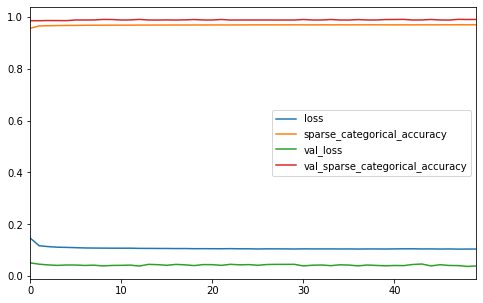

In [12]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

## Transpose and Convert Weights to File

In [13]:
#transpose weight dimension
transposed_l1 = tf.transpose(model.trainable_variables[0])
transposed_l2 = tf.transpose(model.trainable_variables[2])
transposed_l3 = tf.transpose(model.trainable_variables[4])
transposed_l4 = tf.transpose(model.trainable_variables[6])
#transposed_l5 = tf.transpose(model.trainable_variables[8])


In [14]:
convert_weight_to_file(transposed_l1, "w-l1.txt")
convert_weight_to_file(transposed_l2, "w-l2.txt")
convert_weight_to_file(transposed_l3, "w-l3.txt")
convert_weight_to_file(transposed_l4, "w-l4.txt")
#convert_weight_to_file(transposed_l5, "w-l5.txt")


#print(bintoint(weight))

## Plot Confusion Matrix

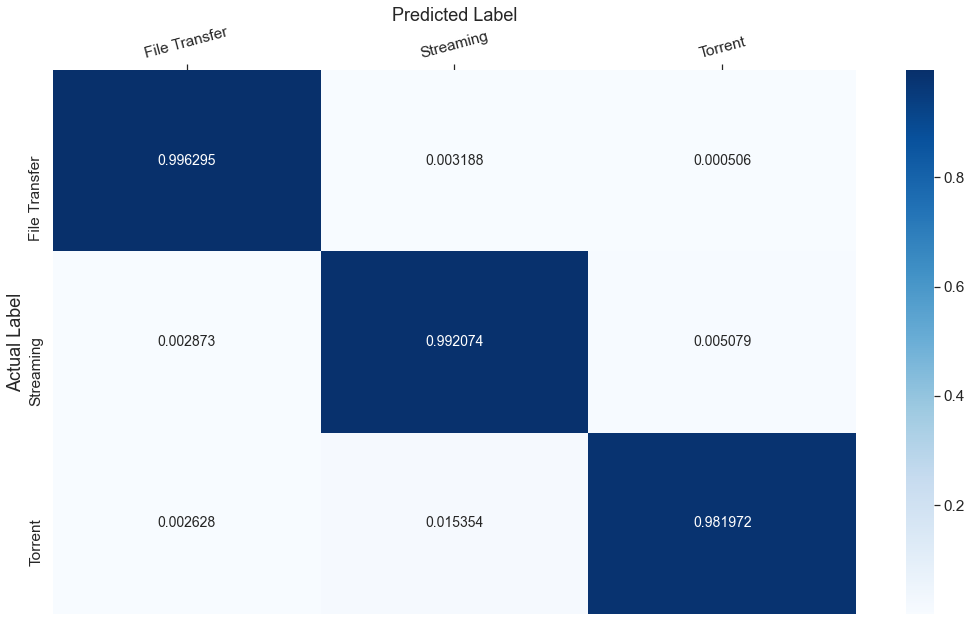

In [15]:
y_prob = model.predict(x_test)
y_classes = y_prob.argmax(axis=-1)
y_actu = pd.Series(y_test, name='Actual')
y_pred = pd.Series(y_classes, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion_norm = (df_confusion / df_confusion.sum(axis=1))
df_confusion_norm = df_confusion_norm.rename(columns={0: "File Transfer", 
                                  1: "Streaming",
                                  2: "Torrent", 
                                  3: "VPN File Transfer", 
                                  4: "VPN Streaming", 
                                  5: "VPN Torrent"})
df_confusion_norm = df_confusion_norm.rename(index={0: "File Transfer", 
                                  1: "Streaming",
                                  2: "Torrent", 
                                  3: "VPN File Transfer", 
                                  4: "VPN Streaming", 
                                  5: "VPN Torrent"})


sn.set(font_scale=1.4) # for label size
plt.subplots(figsize=(18,10))
#plt.title("Confusion Matrix")
ax = sn.heatmap(df_confusion_norm, annot=True, annot_kws={"size": 14}, fmt='f', cmap=plt.cm.Blues)
bottom, top = ax.get_ylim()
ax.xaxis.tick_top()
plt.xticks(rotation=15)
#plt.yticks(rotation=45)
plt.xlabel("Predicted Label", fontsize=18)
plt.ylabel("Actual Label", fontsize=18)
ax.xaxis.set_label_position('top')
ax.set_ylim(bottom, top)
plt.savefig("cm_bnn-rev4.png")
plt.show()

## Recall, Precision, F1 Score

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_actu, y_pred))

## Save Model and Weights

In [16]:
model.save('bnn_56_traffic-rev4.h5')
model.save_weights('bnn_56_traffic_weights-rev4.h5')

## Load Partial NN weights (based on layer name)

In [ ]:
new_inputs = keras.Input(shape=(56,), name="digits")
new_outputs = layers.Dense(6, activation="softmax", name="predictions")(new_inputs)

new_model = keras.Model(inputs=new_inputs, outputs=new_outputs)
new_model.load_weights('coba_bnn_56_traffic_weights.h5', by_name=True)

## Predict One Instance with the New Partial Model

In [ ]:
predictions = new_model.predict(np.array([inttobit(48920584543893867)]))
np.argmax(predictions[0])